In [ ]:
"""
CNN alogrithm for face detection
"""

In [17]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import os
from PIL import Image
import copy


In [29]:
def load_data(data_dir="dataset", img_size=(64, 64)):
    sets = ["train", "test"]
    classes = ["no_face", "face"]

    data = {}

    for s in sets:
        X = []
        y = []

        for label, cls in enumerate(classes):
            class_dir = os.path.join(data_dir, s, cls)

            for file in os.listdir(class_dir):
                img_path = os.path.join(class_dir, file)

                try:
                    img = Image.open(img_path).convert("RGB")
                    img = img.resize(img_size)
                    X.append(np.array(img))
                    y.append(label)
                except:
                    continue  # skip corrupted images

        data[s] = (np.array(X), np.array(y))

    train_x_orig, train_y_orig = data["train"]
    test_x_orig, test_y_orig = data["test"]
    
 
    # Normalize
    train_x = train_x_orig.astype(np.float32) / 255.0
    test_x  = test_x_orig.astype(np.float32) / 255.0
    
  
    train_y = train_y_orig.T
    test_y  = test_y_orig.T
    
    return train_x, train_y, test_x, test_y, np.array(classes)
    

In [30]:
train_x, train_y, test_x, test_y, classes = load_data()

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()

# Input layer first
model.add(Input(shape=(64,64,3)))

# Convolution + ReLU + Pooling
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

# Another conv layer
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

# Flatten for dense layer
model.add(Flatten())

# Fully connected layer
model.add(Dense(64, activation='relu'))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [32]:
history = model.fit(
    train_x, train_y,          # training data and labels
    epochs=10,                 # number of times to iterate over the dataset
    batch_size=32,             # number of examples per gradient update
    validation_data=(test_x, test_y)  # to track accuracy on test set
)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.5357 - loss: 0.7405 - val_accuracy: 0.7596 - val_loss: 0.5959
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.7411 - loss: 0.5817 - val_accuracy: 0.8502 - val_loss: 0.4550
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.9062 - loss: 0.3733 - val_accuracy: 0.8328 - val_loss: 0.3877
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.9330 - loss: 0.2103 - val_accuracy: 0.9094 - val_loss: 0.2268
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.9330 - loss: 0.1462 - val_accuracy: 0.8815 - val_loss: 0.2344
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.9464 - loss: 0.1460 - val_accuracy: 0.9268 - val_loss: 0.2141
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.9688 - loss: 0.0933 - val_accuracy: 0.9303 - val_loss: 0.1674
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.9911 - loss: 0.0550 - val_accuracy: 0.9164 - val_loss: 0.1518

In [33]:
loss, accuracy = model.evaluate(test_x, test_y)
print(f"Test Accuracy: {accuracy*100:.2f}%")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9268 - loss: 0.1497
Test Accuracy: 92.68%


In [34]:
predictions = model.predict(test_x)
predicted_labels = (predictions > 0.5).astype(int)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step 


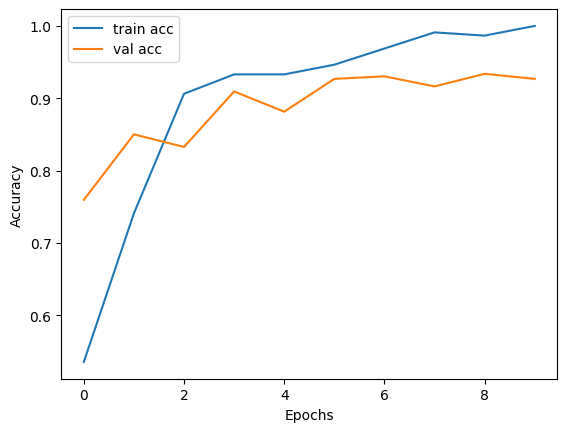

In [35]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [42]:
import matplotlib.pyplot as plt
import time
import random
import numpy as np

def live_test_random_images_cnn(test_x, test_y, classes, model, delay=2):
    """
    Randomly shows test images every `delay` seconds and predicts using a trained CNN.
    
    Arguments:
    test_x -- test images, shape (m, 64, 64, 3)
    test_y -- true labels, shape (m, 1)
    classes -- array like ['no_face', 'face']
    model -- trained Keras CNN model
    delay -- seconds between predictions
    """
    
    num_examples = test_x.shape[0]
    
    while True:
        idx = random.randint(0, num_examples - 1)
        
        img = test_x[idx]              # shape (64, 64, 3)
        true_label = test_y[idx]
        
        # Show image
        plt.imshow(img)
        plt.axis('off')
        plt.show(block=False)
        plt.pause(0.001)
        
        # Predict (model expects batch dimension)
        img_input = np.expand_dims(img, axis=0)  # (1, 64, 64, 3)
        prob = model.predict(img_input, verbose=0)[0][0]
        pred = int(prob > 0.5)
        
        print(
            f"Prediction: {classes[pred]} "
            f"(prob={prob:.2f}) | True label: {classes[true_label]}"
        )
        
        plt.close()
        time.sleep(delay)


In [ ]:
classes = ['no_face', 'face']

live_test_random_images_cnn(
    test_x,
    test_y,
    classes,
    model,
    delay=2
)